# Import Libraries

In [33]:
# Basic analysis tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

# Model preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Model training
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Model saving tools
import joblib

# Data Loading

### Import Data

In [34]:
data = pd.read_csv('train.csv')

Take a look on the data

In [35]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [37]:
data.shape

(8693, 14)

In [38]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

# Exploratory Data Analysis

In [39]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Each of 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' service wasn't used by half of the passengers

## Check Duplicated data

In [40]:
data.duplicated().sum()

0

## Check unique value

In [41]:
## Check unique valuefor column in data.columns:
for column in data.columns:
    print(f"{column}: ", data[column].nunique())

PassengerId:  8693
HomePlanet:  3
CryoSleep:  2
Cabin:  6560
Destination:  3
Age:  80
VIP:  2
RoomService:  1273
FoodCourt:  1507
ShoppingMall:  1115
Spa:  1327
VRDeck:  1306
Name:  8473
Transported:  2


## Dropping and reassign type for columns

### Passenger Name

Passenger Name is not used for machine learning, so we will drop 'Name' column

In [42]:
data.drop('Name', axis = 1, inplace = True) 

### Passenger ID

Passenger Id is also not used for machine learning, but how many colleague/family they have in the ship **might** affect whether the passenger is transported

In [43]:
# Separate Passenger ID to group and the number between the group
data[["Passenger_Group", "Passenger_Number_Group"]] = data["PassengerId"].str.split("_", expand=True)

# Drop PassengerId Original Column
data.drop('PassengerId', axis = 1, inplace = True)

# Change Passenger Number Group to Integer

data['Passenger_Number_Group'] = data['Passenger_Number_Group'].astype(int)

# Find how many people in the group
data['people_in_group'] = data.groupby(['Passenger_Group'])['Passenger_Number_Group'].transform(max)

# Delete Passenger_Group and Passenger_Number_Group column

data.drop(['Passenger_Group','Passenger_Number_Group'], axis = 1, inplace = True)

data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,people_in_group
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1


### Cabin Column Split

In [44]:
# Separate Deck, Cabin Number, and Side
data[["Deck", "Cabin_num", "Side"]] = data["Cabin"].str.split("/", expand=True)

# Drop origina Cabin Column
data.drop('Cabin', axis = 1, inplace = True)

data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,people_in_group,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,1,S


## General Exploratory

In [45]:
# Check how many are transported and how many are alive
data['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

More than half of the passenger are transported

#### Check other columns

In [46]:
# Home Planet
data['HomePlanet'].value_counts()


Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [47]:
data['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [48]:
data['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [49]:
data['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

#### For Home Planet and Destination

In [50]:
# Function for plotting count
def count_plots(dataframe, columns:list):
    n = len(columns)
    plt.figure(figsize=(8,(n*4)))

    for i, cols in enumerate(columns):
        # Boxplot
        plt.subplot(n, 1, i+1)
        plt.title(cols.capitalize())
        ax = sns.countplot(data=dataframe, x=cols, palette=sns.color_palette("magma"))
        ax.set_facecolor("#D9D9D9")
        ax.spines["bottom"].set_color("black")
        ax.spines[["top", "right"]].set_visible(False)
        ax.tick_params(axis="x", colors="black", labelsize=12)
        ax.tick_params(axis="y", colors="black", labelsize=12)
        ax.set(xlabel=None, ylabel=None)
        ax.bar_label(ax.containers[0])

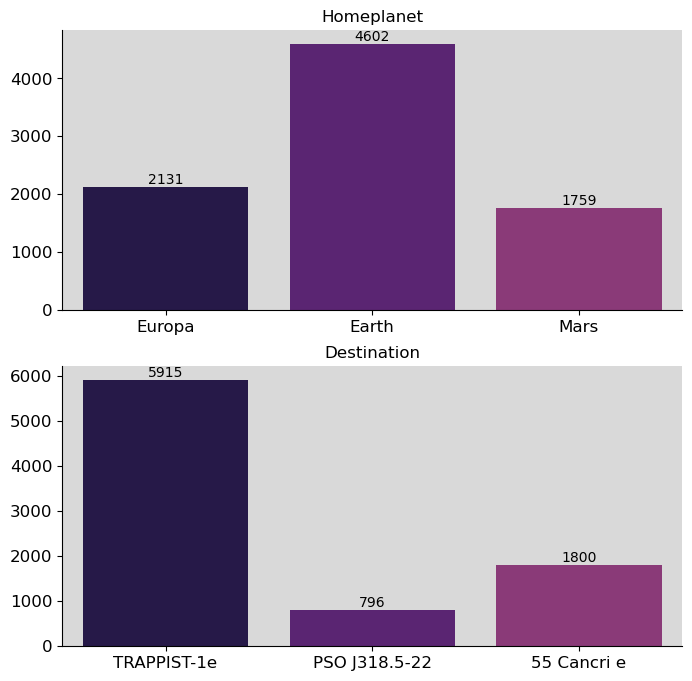

In [51]:
# Plot jumlah data berdasarkan marital status dan sex
count_plots(
    data,
    [
        "HomePlanet",
        "Destination",
    ],
)

Most of the passenger were from Earth and most of them were heading to TRAPPIST-1e

#### Check for numerical data

In [52]:
num_data_columns = data.select_dtypes("number").columns.to_list()

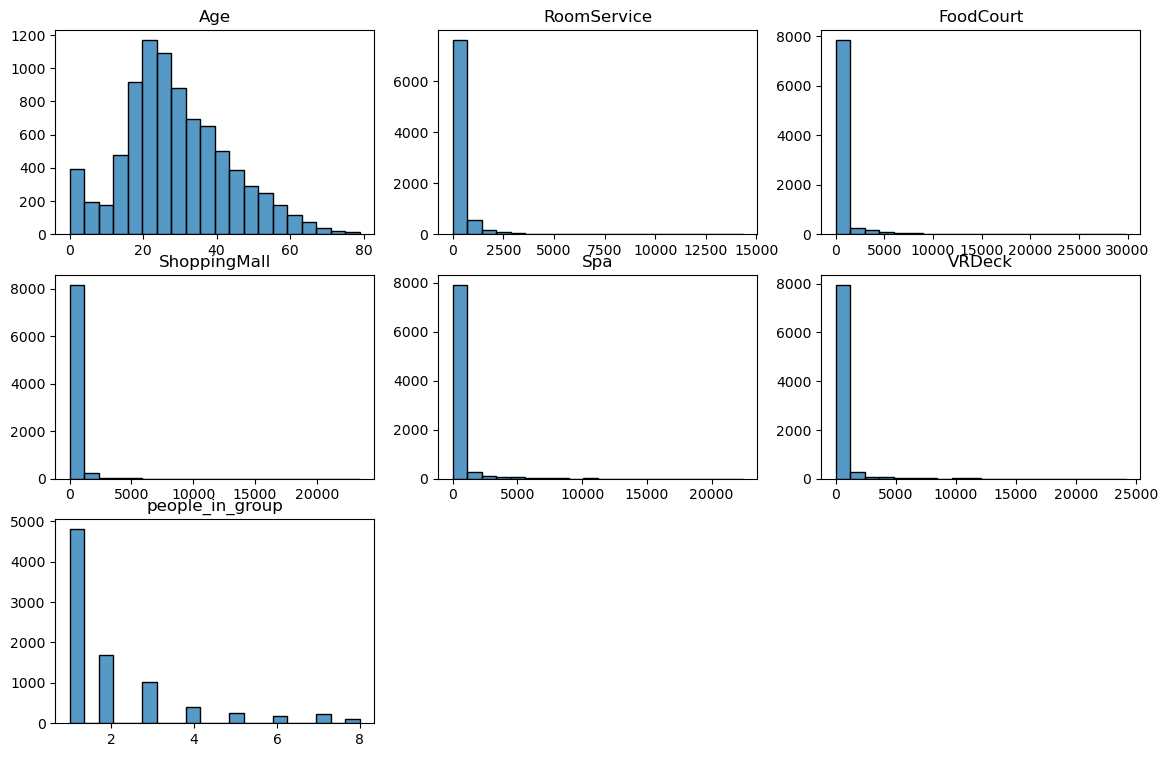

In [53]:
n = len(num_data_columns)
plt.figure(figsize=((n*2),(n+2)))


for i in range(n):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[num_data_columns[i]], bins=20)
    plt.title(num_data_columns[i])
    plt.xlabel("")
    plt.ylabel("")

## Check Feature Correlation

In [54]:
data.select_dtypes("number").corr()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.179102
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.040777
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.032632
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,-0.038770
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,0.019223
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,0.009401
people_in_group,-0.179102,-0.040777,0.032632,-0.038770,0.019223,0.009401,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

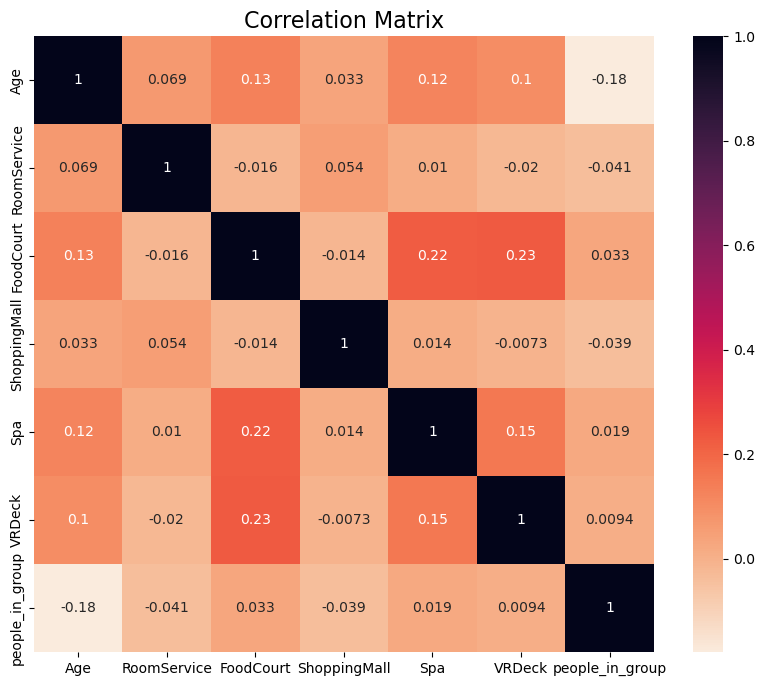

In [55]:
correlation_plot = plt.figure(figsize=(10, 8))
sns.heatmap(data.select_dtypes(['number']).corr(), annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.title('Correlation Matrix', fontsize=16)

Almost no correlation between numerical columns

# Data Splitting

In [56]:
X = data.drop(["Transported"], axis=1)
y = data["Transported"]

In [57]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,2,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1,S


In [58]:
y.head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

print('Train data length : ', X_train.shape[0])
print('Test data length : ', X_val.shape[0])

Train data length :  6954
Test data length :  1739


#### Check proprtion

In [60]:
data['Transported'].value_counts(normalize = True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

In [61]:
y_train.value_counts(normalize=True)

True     0.503595
False    0.496405
Name: Transported, dtype: float64

In [62]:
y_val.value_counts(normalize=True)

True     0.503738
False    0.496262
Name: Transported, dtype: float64

Data proportion is kept the same

# Preprocessing

## Outlier Handling

In [63]:
# Function for plotting outlier
def outlier_plot(dataframe, features:list):
    n = len(features)
    
    # Inisiasi figure
    plt.figure(figsize=(10, (n*4)))

    # Lakukan looping untuk fitur diinput
    for i, ft in enumerate(features):

        # Boxplot
        plt.subplot(n, 2, i*2+1)
        plt.title(ft.capitalize())
        sns.boxplot(dataframe[ft])

        # Histogram
        plt.subplot(n, 2, i*2+2)
        plt.ylabel(" ")
        plt.xlabel(" ")
        sns.histplot(dataframe[ft], bins=15)
        print(f"Nilai Skewness {ft}: ", dataframe[ft].skew())
        print(f"Nilai Kurtosis {ft}: ", dataframe[ft].kurt(), end="\n\n")

Nilai Skewness Age:  0.4196249954477674
Nilai Kurtosis Age:  0.10797333653015162

Nilai Skewness RoomService:  6.321131545742857
Nilai Kurtosis RoomService:  66.9610061663872

Nilai Skewness FoodCourt:  7.277245160751891
Nilai Kurtosis FoodCourt:  76.99781145349498

Nilai Skewness ShoppingMall:  13.136869397569198
Nilai Kurtosis ShoppingMall:  340.56181828842693

Nilai Skewness Spa:  7.9512041243731435
Nilai Kurtosis Spa:  87.38654668904707

Nilai Skewness VRDeck:  8.009420290128796
Nilai Kurtosis VRDeck:  93.29259309106162

Nilai Skewness people_in_group:  1.8758874556069398
Nilai Kurtosis people_in_group:  3.140580468674149



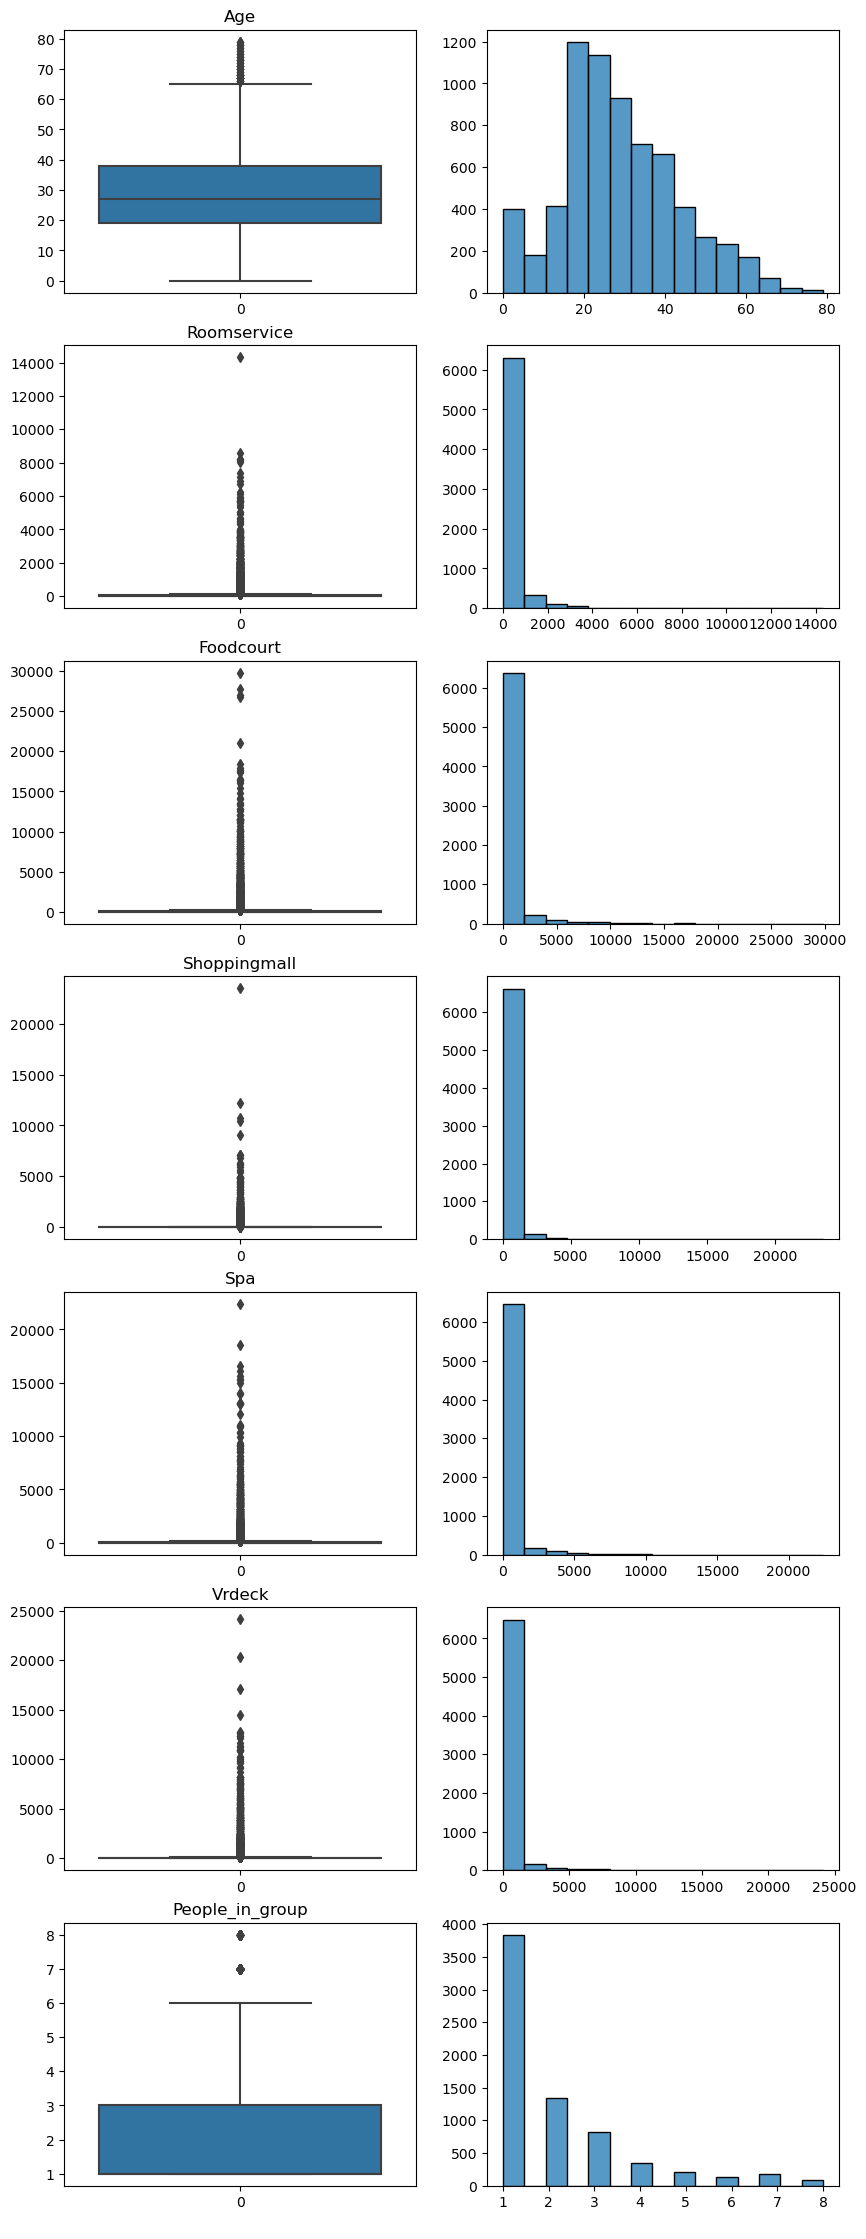

In [64]:
# Plot outlier for numerical values
outlier_plot(
    X_train,
    ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'people_in_group']
)

In [65]:
# Function for detecting outlier using IQR (non normal distribution)
def check_iqr(data, variable, distance=1.5):
    iqr = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    lower_limit = data[variable].quantile(0.25) - (iqr * distance)
    upper_limit = data[variable].quantile(0.75) + (iqr * distance)
    print(variable)
    print("Upper Limint Outlier: ", upper_limit)
    print("Lower Limint Outlier: ", lower_limit)
    outlier_count = (
        data[
            (data[variable]
            > upper_limit)
            | (data[variable] < lower_limit)
        ]
        .count()
        .values[0]
    )
    print("Outlier Count: ", outlier_count)
    print(
        "Outlier percentage: ",
        round(outlier_count / data.shape[0] * 100, 2),
        "%",
    end="\n\n",
    )
    return upper_limit, lower_limit

In [66]:
for cols in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'people_in_group']:
    check_iqr(X_train, cols, 3)

Age
Upper Limint Outlier:  94.0
Lower Limint Outlier:  -37.25
Outlier Count:  0
Outlier percentage:  0.0 %

RoomService
Upper Limint Outlier:  220.0
Lower Limint Outlier:  -165.0
Outlier Count:  1261
Outlier percentage:  18.13 %

FoodCourt
Upper Limint Outlier:  316.0
Lower Limint Outlier:  -237.0
Outlier Count:  1258
Outlier percentage:  18.09 %

ShoppingMall
Upper Limint Outlier:  112.0
Lower Limint Outlier:  -84.0
Outlier Count:  1314
Outlier percentage:  18.9 %

Spa
Upper Limint Outlier:  228.0
Lower Limint Outlier:  -171.0
Outlier Count:  1244
Outlier percentage:  17.89 %

VRDeck
Upper Limint Outlier:  178.0
Lower Limint Outlier:  -133.5
Outlier Count:  1279
Outlier percentage:  18.39 %

people_in_group
Upper Limint Outlier:  9.0
Lower Limint Outlier:  -5.0
Outlier Count:  0
Outlier percentage:  0.0 %



There are many outliers in 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'. It can be caused by the fact that for more than half of the passenger did not pay for it

So we will try to check it manually

#### Room Service Outlier

In [67]:
X_train.sort_values('RoomService', ascending=False).head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
4416,Europa,False,TRAPPIST-1e,27.0,False,14327.0,1487.0,0.0,1.0,0.0,2,NaN,NaN,NaN
8626,Europa,False,TRAPPIST-1e,26.0,False,8586.0,77.0,114.0,29.0,4.0,1,C,309,P
7118,Europa,False,TRAPPIST-1e,39.0,NaN,8209.0,18.0,432.0,3560.0,54.0,4,C,281,S
1177,Europa,False,TRAPPIST-1e,32.0,False,8168.0,69.0,11.0,371.0,0.0,2,A,9,P
4762,Europa,False,TRAPPIST-1e,32.0,False,8151.0,2052.0,1919.0,7352.0,754.0,2,E,315,P
928,Europa,False,55 Cancri e,35.0,True,8030.0,300.0,0.0,0.0,1436.0,6,NaN,NaN,NaN
75,Mars,False,TRAPPIST-1e,42.0,False,7406.0,0.0,0.0,0.0,0.0,3,F,16,P
1459,Mars,False,TRAPPIST-1e,13.0,False,7172.0,0.0,157.0,20.0,0.0,1,F,299,S
8470,Europa,False,TRAPPIST-1e,25.0,False,6899.0,265.0,0.0,2234.0,2090.0,2,C,335,S
1958,Mars,False,TRAPPIST-1e,13.0,NaN,6726.0,0.0,1605.0,1266.0,0.0,5,NaN,NaN,NaN


There's one person that pay significantly more for RoomService compared to other passengers. We will handle it

In [68]:
outlier_RoomService = X_train.sort_values('RoomService', ascending=False).iloc[[0]].index.to_list()
outlier_RoomService

[4416]

#### Food Court Outlier

In [69]:
X_train.sort_values('FoodCourt', ascending=False).head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
2067,Europa,False,55 Cancri e,41.0,True,0.0,29813.0,0.0,1257.0,6.0,4,A,27,S
1213,Europa,False,55 Cancri e,31.0,True,0.0,27723.0,3.0,202.0,3146.0,2,B,55,S
3198,Europa,False,55 Cancri e,33.0,False,0.0,27071.0,0.0,15.0,0.0,4,B,131,S
3538,Europa,False,55 Cancri e,33.0,False,90.0,26830.0,0.0,27.0,703.0,1,B,121,P
1842,Europa,False,55 Cancri e,27.0,False,NaN,21066.0,0.0,2448.0,2293.0,1,C,75,S
3180,Europa,False,TRAPPIST-1e,27.0,False,0.0,18481.0,0.0,2.0,3875.0,2,C,113,P
7520,Europa,False,55 Cancri e,45.0,False,5.0,17901.0,0.0,79.0,281.0,4,A,97,S
4083,Europa,False,55 Cancri e,40.0,False,0.0,17687.0,0.0,425.0,155.0,3,C,137,P
3428,Europa,False,55 Cancri e,25.0,NaN,0.0,17432.0,0.0,241.0,2102.0,4,C,123,P
1496,Europa,False,55 Cancri e,35.0,False,0.0,17394.0,0.0,724.0,0.0,2,E,99,P


There's four people that pay significantly more for Food Court compared to other passengers. We will handle it

In [70]:
outlier_FoodCourt = X_train.sort_values('FoodCourt', ascending=False).iloc[0:4].index.to_list()
outlier_FoodCourt

[2067, 1213, 3198, 3538]

#### Shopping Mall Outlier

In [71]:
X_train.sort_values('ShoppingMall', ascending=False).head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
8415,Europa,False,TRAPPIST-1e,17.0,False,0.0,366.0,23492.0,356.0,3.0,4,B,291,P
6223,Europa,False,TRAPPIST-1e,13.0,False,0.0,100.0,12253.0,6.0,80.0,2,B,254,S
7425,Europa,False,TRAPPIST-1e,41.0,False,0.0,116.0,10705.0,9181.0,10.0,1,C,257,P
4724,Europa,False,TRAPPIST-1e,26.0,False,0.0,21.0,10424.0,1373.0,7218.0,2,C,195,S
5673,Europa,False,TRAPPIST-1e,36.0,False,0.0,1828.0,9058.0,1.0,2.0,1,B,232,S
8315,Europa,False,55 Cancri e,44.0,False,0.0,71.0,7148.0,427.0,394.0,1,B,287,P
637,NaN,False,TRAPPIST-1e,28.0,False,NaN,0.0,7104.0,0.0,0.0,2,F,141,P
5137,Europa,False,TRAPPIST-1e,15.0,False,0.0,22.0,6805.0,0.0,531.0,4,B,186,P
7950,Mars,False,55 Cancri e,35.0,False,319.0,0.0,6331.0,8.0,0.0,1,F,1635,S
8078,Mars,False,TRAPPIST-1e,25.0,False,987.0,0.0,6221.0,141.0,0.0,3,F,1773,P


There's one person that pay significantly more for Shopping Mall compared to other passengers. We will handle it

In [72]:
outlier_ShoppingMall = X_train.sort_values('ShoppingMall', ascending=False).iloc[[0]].index.to_list()
outlier_ShoppingMall

[8415]

#### Spa Outlier

In [73]:
X_train.sort_values('Spa', ascending=False).head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
5722,Europa,False,55 Cancri e,68.0,False,125.0,13437.0,0.0,22408.0,17.0,1,C,186,P
7995,Europa,False,TRAPPIST-1e,18.0,False,0.0,1878.0,0.0,18572.0,10028.0,2,B,280,P
1390,Europa,False,55 Cancri e,76.0,False,0.0,2732.0,422.0,16594.0,330.0,5,B,62,S
1095,Europa,False,55 Cancri e,19.0,False,0.0,1291.0,0.0,16139.0,687.0,2,B,48,S
6921,Europa,False,NaN,33.0,False,0.0,2107.0,0.0,15586.0,473.0,1,E,474,P
1598,Europa,False,TRAPPIST-1e,43.0,False,0.0,760.0,17.0,15331.0,427.0,1,B,55,P
4278,Europa,False,55 Cancri e,54.0,False,0.0,559.0,0.0,15238.0,2799.0,1,C,167,S
154,Europa,False,TRAPPIST-1e,38.0,False,0.0,10346.0,1.0,14970.0,2111.0,1,B,2,S
8459,Europa,False,55 Cancri e,27.0,False,0.0,984.0,0.0,13995.0,312.0,5,D,288,P
7065,Europa,False,PSO J318.5-22,32.0,True,2502.0,700.0,1104.0,13902.0,484.0,2,B,246,P


There's one person that pay significantly more for Spa compared to other passengers. We will handle it

In [74]:
outlier_Spa = X_train.sort_values('Spa', ascending=False).iloc[[0]].index.to_list()
outlier_Spa

[5722]

#### VR Deck

In [75]:
X_train.sort_values('VRDeck', ascending=False).head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
5619,Europa,False,55 Cancri e,57.0,False,200.0,9.0,0.0,NaN,24133.0,4,B,230,S
4311,Europa,False,TRAPPIST-1e,31.0,False,0.0,6670.0,217.0,625.0,20336.0,4,C,144,P
6547,Europa,False,TRAPPIST-1e,60.0,False,0.0,960.0,46.0,854.0,17074.0,1,C,254,S
3916,Europa,False,55 Cancri e,31.0,False,2.0,8747.0,0.0,4840.0,14485.0,6,C,133,P
4551,Europa,False,TRAPPIST-1e,25.0,False,21.0,2148.0,0.0,1966.0,12708.0,3,B,192,S
8171,Europa,False,TRAPPIST-1e,20.0,False,NaN,7759.0,18.0,4925.0,12685.0,2,E,559,P
4319,Europa,False,TRAPPIST-1e,36.0,False,1.0,5234.0,343.0,277.0,12682.0,2,C,171,S
8442,Europa,False,55 Cancri e,41.0,False,3.0,1320.0,0.0,0.0,12392.0,1,B,344,S
4941,Europa,False,55 Cancri e,36.0,True,13.0,196.0,3.0,0.0,12323.0,2,C,205,S
7978,Europa,False,55 Cancri e,28.0,False,0.0,101.0,0.0,0.0,12143.0,1,E,559,S


There are two people that pay significantly more for VR Deck compared to other passengers. We will handle it

In [76]:
outlier_VRDeck = X_train.sort_values('VRDeck', ascending=False).iloc[0:2].index.to_list()
outlier_VRDeck

[5619, 4311]

### Drop Outlier

The easiest way to handle outliers are by dropping them, but we have to check do we have enough data

In [77]:
#Combine outlier
outlier_index = list(set(outlier_RoomService + outlier_FoodCourt + outlier_ShoppingMall + outlier_VRDeck))
print(outlier_index)
print(len(outlier_index))
print(100*len(outlier_index)/len(X_train), "% of X train")

[4416, 3538, 2067, 5619, 4311, 1213, 3198, 8415]
8
0.11504170261719873 % of X train


We have enough data thus it's safe to drop the outlier

In [78]:
X_train_no_outlier = X_train.drop(outlier_index)
X_train_no_outlier.shape

(6946, 14)

In [79]:
y_train_no_outlier = y_train.drop(outlier_index)
y_train_no_outlier.shape

(6946,)

## Missing Values Handling

In [80]:
X_train_no_outlier.isnull().sum()

HomePlanet         164
CryoSleep          172
Destination        139
Age                144
VIP                149
RoomService        146
FoodCourt          150
ShoppingMall       167
Spa                139
VRDeck             155
people_in_group      0
Deck               155
Cabin_num          155
Side               155
dtype: int64

In [81]:
X_train_imputed = X_train_no_outlier.copy()

In [82]:
X_val_imputed = X_val.copy()

### Numerical Columns

In [83]:
num_data_columns = X_train_imputed.select_dtypes("number").columns.to_list()
num_data_columns

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'people_in_group']

We will use Median for Age imputation and 0 for 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' imputation. But since 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' median is 0. We will use Median for all of them

In [84]:
for column in num_data_columns:
    X_train_imputed[column] = X_train_imputed[column].fillna(X_train_imputed[column].median())

In [85]:
X_train_imputed.isnull().sum()

HomePlanet         164
CryoSleep          172
Destination        139
Age                  0
VIP                149
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
people_in_group      0
Deck               155
Cabin_num          155
Side               155
dtype: int64

and also for X_Validation

In [86]:
for column in num_data_columns:
    X_val_imputed[column] = X_val_imputed[column].fillna(X_train_imputed[column].median())

In [87]:
X_val_imputed.isnull().sum()

HomePlanet         37
CryoSleep          45
Destination        43
Age                 0
VIP                54
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
people_in_group     0
Deck               43
Cabin_num          43
Side               43
dtype: int64

### Categorical Columns

For categorical columns, we use mode as the imputation method

In [88]:
X_train_categorical = X_train_imputed.drop(num_data_columns, axis = 1)

In [89]:
categorical_column = X_train_categorical.columns.to_list()
categorical_column

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Cabin_num', 'Side']

In [90]:
for column in categorical_column:
    X_train_imputed[column] = X_train_imputed[column].fillna(X_train_imputed[column].mode()[0])

In [91]:
X_train_imputed.isnull().sum()

HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
people_in_group    0
Deck               0
Cabin_num          0
Side               0
dtype: int64

and also for X_validation

In [92]:
for column in categorical_column:
    X_val_imputed[column] = X_val_imputed[column].fillna(X_train_imputed[column].mode()[0])

In [93]:
X_val_imputed.isnull().sum()

HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
people_in_group    0
Deck               0
Cabin_num          0
Side               0
dtype: int64

## Feature Selection

We will use t-test for numerical value and chi-square for categorical value

H0 = Feature has no correlation with target


H1 = Feature has a correlation with target

In [94]:
for ft in X_train_imputed[num_data_columns]:
    target_true_data = X_train_imputed[y_train_no_outlier == True][ft]
    target_false_data = X_train_imputed[y_train_no_outlier == False][ft]

    # Lakukan t-test
    f_statistic, p_value = ttest_ind(target_true_data, target_false_data)

    # Lihat p-valuenya
    if p_value < 0.05:
        # Gagal tolak null hypothesis 
        print(f"Reject there is no correlation between'{ft}' and if the passenger is transported")
    else:
        # Tolak null hypothesis 
        print(f"Failed to reject there is correlation between'{ft}' and if the passenger is transported")

Reject there is no correlation between'Age' and if the passenger is transported
Reject there is no correlation between'RoomService' and if the passenger is transported
Reject there is no correlation between'FoodCourt' and if the passenger is transported
Failed to reject there is correlation between'ShoppingMall' and if the passenger is transported
Reject there is no correlation between'Spa' and if the passenger is transported
Reject there is no correlation between'VRDeck' and if the passenger is transported
Reject there is no correlation between'people_in_group' and if the passenger is transported


In [95]:
for ft in X_train_imputed[categorical_column]:
    contingency_table = pd.crosstab(y_train_no_outlier, X_train_imputed[ft])

    # Lakukan chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Lihat p-valuenya
    if p_value < 0.05: 
        # Gagal tolak null hypothesis 
        print(f"Reject there is no correlation between'{ft}' and if the passenger is transported")
    else:
        # Tolak null hypothesis 
        print(f"Failed to reject there is correlation between'{ft}' and if the passenger is transported")

Reject there is no correlation between'HomePlanet' and if the passenger is transported
Reject there is no correlation between'CryoSleep' and if the passenger is transported
Reject there is no correlation between'Destination' and if the passenger is transported
Reject there is no correlation between'VIP' and if the passenger is transported
Reject there is no correlation between'Deck' and if the passenger is transported
Reject there is no correlation between'Cabin_num' and if the passenger is transported
Reject there is no correlation between'Side' and if the passenger is transported


we will not use 'ShoppingMall' feature for modeling

In [96]:
X_train_imputed[categorical_column].nunique()

HomePlanet        3
CryoSleep         2
Destination       3
VIP               2
Deck              8
Cabin_num      1739
Side              2
dtype: int64

we will not use 'Deck' 'Cabin_num' feature for modeling because they have too many unique data

## Split Categorical and Numerical data

In [97]:
# Categorical Columns
cat_columns = [
    'HomePlanet',
    'CryoSleep',
    'Destination',
    'VIP',
    'Side'    
]

# Numerical Columns
num_columns = [
    "Age",
    "RoomService",
    "FoodCourt",
    "Spa",
    "VRDeck",
    'people_in_group'
]
print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['Age', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck', 'people_in_group']
Cat Columns :  ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Side']


In [98]:
X_train_num = X_train_imputed[num_columns]
X_train_cat = X_train_imputed[cat_columns]

X_val_num = X_val_imputed[num_columns]
X_val_cat = X_val_imputed[cat_columns]

X_train_cat.head(10)

,HomePlanet,CryoSleep,Destination,VIP,Side
4669,Earth,False,TRAPPIST-1e,False,S
75,Mars,False,TRAPPIST-1e,False,P
1239,Mars,False,TRAPPIST-1e,False,P
4489,Mars,True,TRAPPIST-1e,False,P
5324,Earth,False,TRAPPIST-1e,False,S
4513,Mars,False,TRAPPIST-1e,False,S
7878,Mars,False,TRAPPIST-1e,False,S
7390,Mars,True,TRAPPIST-1e,False,S
6931,Europa,False,TRAPPIST-1e,False,S
4901,Mars,True,TRAPPIST-1e,False,S


## Numerical Value Encoding

In [99]:
# create object
encoder = OrdinalEncoder()

# Fitting encoder
encoder.fit(X_train_cat)

OrdinalEncoder()

In [100]:
X_train_encoded = encoder.transform(X_train_cat)
X_val_encoded = encoder.transform(X_val_cat)
X_train_encoded

array([[0., 0., 2., 0., 1.],
       [2., 0., 2., 0., 0.],
       [2., 0., 2., 0., 0.],
       ...,
       [1., 0., 0., 0., 1.],
       [1., 1., 2., 0., 1.],
       [0., 1., 2., 0., 1.]])

## Combine Data

In [101]:
X_train_concat = np.concatenate([X_train_num, X_train_encoded], axis=1)
X_val_concat = np.concatenate([X_val_num, X_val_encoded], axis=1)

## Feature Scaling

We use MinMax scaler instead of StandardScaler because most of the columns doesn't have gaussian distribution

In [102]:
# Create Object
scaler = MinMaxScaler(feature_range=(0,1))

# Fit scaler pada train data
scaler.fit(X_train_concat)

# Transformasi data train dan test
X_train_scaled = scaler.transform(X_train_concat)
X_val_scaled = scaler.transform(X_val_concat)

X_train_scaled

array([[0.40506329, 0.32098765, 0.00593373, ..., 1.        , 0.        ,
        1.        ],
       [0.53164557, 0.86256697, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.21518987, 0.1104123 , 0.00223108, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.6835443 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.32911392, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ]])

### Change variable name to final

In [103]:
X_train_final = X_train_scaled
y_train_final = y_train_no_outlier
X_val_final = X_val_scaled

# Modelling

#### Create objects

In [104]:
# Logistic regression
logreg = LogisticRegression()

# Support vector classifier
svc = SVC()

# Random forest classifier
rfc = RandomForestClassifier(random_state=123)

# K-Nearest neighbor
knn = KNeighborsClassifier()

# Gradient boost
gbc = GradientBoostingClassifier(random_state=123)

# Extreme gradient boost
xgb = XGBClassifier()

In [105]:
estimators = [
    {"algorithm": logreg, "name": "Logistic Regression"},
    {"algorithm": svc, "name": "Support Vector Classifier"},
    {"algorithm": rfc, "name": "Random Forest Classifier"},
    {"algorithm": knn, "name": "K-Nearest Neighbor"},
    {"algorithm": gbc, "name": "Gradient Boost Classifier"},
    {"algorithm": xgb, "name": "Extreme Gradient Boost"},
]

## Model Training

In [106]:
def create_report(actual, prediction, matrix:bool=False, name:str="Plot"):
    print(classification_report(actual, prediction))
    if matrix:
        ConfusionMatrixDisplay(confusion_matrix(actual, prediction)).plot()
        plt.title(name)

In [108]:
baseline_model =  DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train_final, y_train_final)
y_baseline = baseline_model.predict(X_train_final)
create_report(y_train_final, y_baseline)


              precision    recall  f1-score   support

       False       0.00      0.00      0.00      3449
        True       0.50      1.00      0.67      3497

    accuracy                           0.50      6946
   macro avg       0.25      0.50      0.33      6946
weighted avg       0.25      0.50      0.34      6946



C:\Users\p3d3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\p3d3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\p3d3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
#Train every estimators
for est in estimators:
    est["algorithm"].fit(X_train_final, y_train_final)

In [76]:
for est in estimators:
    name = est["name"]
    print(name)
    y_pred = est["algorithm"].predict(X_train_final)
    create_report(y_train_final, y_pred)

Logistic Regression
              precision    recall  f1-score   support

       False       0.73      0.83      0.78      3449
        True       0.80      0.70      0.75      3497

    accuracy                           0.76      6946
   macro avg       0.77      0.77      0.76      6946
weighted avg       0.77      0.76      0.76      6946

Support Vector Classifier
              precision    recall  f1-score   support

       False       0.73      0.85      0.78      3449
        True       0.82      0.69      0.75      3497

    accuracy                           0.77      6946
   macro avg       0.77      0.77      0.77      6946
weighted avg       0.77      0.77      0.77      6946

Random Forest Classifier
              precision    recall  f1-score   support

       False       0.98      0.94      0.96      3449
        True       0.94      0.98      0.96      3497

    accuracy                           0.96      6946
   macro avg       0.96      0.96      0.96      6946
wei

Estimator with highest accuracy: Random Forest, XGB and KNN

Estimator with highest recall: Random Forest, XGB and KNN

## Validation

In [83]:
#random_forest
y_train_predict = rfc.predict(X_train_final)
y_val_predict = rfc.predict(X_val_final)

create_report(y_train_final, y_train_predict)
create_report(y_val, y_val_predict,)

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      3449
        True       0.94      0.98      0.96      3497

    accuracy                           0.96      6946
   macro avg       0.96      0.96      0.96      6946
weighted avg       0.96      0.96      0.96      6946

              precision    recall  f1-score   support

       False       0.76      0.80      0.78       863
        True       0.79      0.75      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [84]:
#xgb
y_train_predict = xgb.predict(X_train_final)
y_val_predict = xgb.predict(X_val_final)

create_report(y_train_final, y_train_predict)
create_report(y_val, y_val_predict,)


              precision    recall  f1-score   support

       False       0.92      0.85      0.89      3449
        True       0.87      0.93      0.90      3497

    accuracy                           0.89      6946
   macro avg       0.89      0.89      0.89      6946
weighted avg       0.89      0.89      0.89      6946

              precision    recall  f1-score   support

       False       0.80      0.76      0.78       863
        True       0.77      0.82      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [85]:
#k-nn
y_train_predict = knn.predict(X_train_final)
y_val_predict = knn.predict(X_val_final)

create_report(y_train_final, y_train_predict)
create_report(y_val, y_val_predict,)

              precision    recall  f1-score   support

       False       0.82      0.81      0.82      3449
        True       0.82      0.83      0.82      3497

    accuracy                           0.82      6946
   macro avg       0.82      0.82      0.82      6946
weighted avg       0.82      0.82      0.82      6946

              precision    recall  f1-score   support

       False       0.75      0.73      0.74       863
        True       0.74      0.76      0.75       876

    accuracy                           0.74      1739
   macro avg       0.74      0.74      0.74      1739
weighted avg       0.74      0.74      0.74      1739



All model accuracies score fell when predicting test, it might be because of overfit

## Hyperparameter Tuning

### Hyperparameter Definition

In [109]:
# Hyperparameter Random Forest Classifier
rfc_params = {
    "n_estimators": [90, 100, 110],
    "criterion": ["gini", "entropy"],
    "max_depth": [15, 20, 25, 30],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8],
    "random_state": [123],
}

# Hyperparameter Extreme Gradient Boosting
xgb_params = {
    "learning_rate": [0.05, 0.1, 0.3, 0.5, 1, 5, 10],
    "n_estimators": [50, 80, 100, 150, 200],
    "max_depth": [1, 2, 3, 4, 5, 6, 7],
    "random_state": [100],
}

# Hyperparameter K nearest Neighbor
knn_params = {
    "n_neighbors": [3, 4, 5, 6, 7, 8, 9, 10],
    "leaf_size": [10, 30, 50, 100, 150, 200, 300],
    "algorithm": ['ball_tree', 'kd_tree']
}

### Gridsearch

#### Random Forest Classifier

In [162]:
grid_search_rfc = GridSearchCV(rfc, rfc_params, scoring="f1", cv=5, n_jobs=4, return_train_score=True)
grid_search_rfc.fit(X_train_final, y_train_final)
best_scores = {
    'best_params': grid_search_rfc.best_params_,
    'best_score': grid_search_rfc.best_score_,
    'best_estimator': grid_search_rfc.best_estimator_
}

In [163]:
print(f"Model Random Foret Classifier")
print(f"Best Parameters: {grid_search_rfc.best_params_}")
print(f"Best Score: {grid_search_rfc.best_score_}")
print(f"Best Estimator: {grid_search_rfc.best_estimator_}")

Model Random Foret Classifier
Best Parameters: {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123}
Best Score: 0.7964652617991522
Best Estimator: RandomForestClassifier(max_depth=25, min_samples_leaf=8, random_state=123)


Fit with best parameter

In [164]:
#new rfc objects
best_rfc = RandomForestClassifier().set_params(**grid_search_rfc.best_params_)

In [165]:
best_rfc.fit(X_train_final, y_train_final)

RandomForestClassifier(max_depth=25, min_samples_leaf=8, random_state=123)

In [166]:
y_train_rf = best_rfc.predict(X_train_final)
y_val_rf = best_rfc.predict(X_val_final)

In [167]:
print(classification_report(y_train_final,y_train_rf))
print(classification_report(y_val,y_val_rf))

              precision    recall  f1-score   support

       False       0.85      0.82      0.83      3449
        True       0.83      0.86      0.84      3497

    accuracy                           0.84      6946
   macro avg       0.84      0.84      0.84      6946
weighted avg       0.84      0.84      0.84      6946

              precision    recall  f1-score   support

       False       0.81      0.77      0.79       863
        True       0.78      0.82      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



#### XGBoost

In [96]:
# Grid search Extreme Gradient Boosting
grid_search_xgb = GridSearchCV(xgb, xgb_params, scoring="f1", cv=5, n_jobs=4, return_train_score=True)
grid_search_xgb.fit(X_train_final, y_train_final)
best_scores = {
    'best_params': grid_search_xgb.best_params_,
    'best_score': grid_search_xgb.best_score_,
    'best_estimator': grid_search_xgb.best_estimator_
}

C:\Users\p3d3\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [20:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


In [99]:
print(f"Model Extreme Gradient Boost")
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best Score: {grid_search_xgb.best_score_}")
print(f"Best Estimator: {grid_search_xgb.best_estimator_}")

Model Extreme Gradient Boost
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50, 'random_state': 123}
Best Score: 0.8027974748397341
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_leaf=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)


Fit with best parameter

In [125]:
#new xgb objects
best_xgb = XGBClassifier().set_params(**grid_search_xgb.best_params_)

In [126]:
best_xgb.fit(X_train_final, y_train_final)

C:\Users\p3d3\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [21:18:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_leaf=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [127]:
y_train_xgb = best_xgb.predict(X_train_final)
y_val_xgb = best_xgb.predict(X_val_final)

In [128]:
print(classification_report(y_train_final,y_train_xgb))
print(classification_report(y_val,y_val_xgb))

              precision    recall  f1-score   support

       False       0.84      0.75      0.79      3449
        True       0.78      0.85      0.81      3497

    accuracy                           0.80      6946
   macro avg       0.81      0.80      0.80      6946
weighted avg       0.81      0.80      0.80      6946

              precision    recall  f1-score   support

       False       0.83      0.73      0.77       863
        True       0.76      0.85      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



#### K-NN

In [135]:
grid_search_knn = GridSearchCV(knn, knn_params, scoring="f1", cv=5, n_jobs=4, return_train_score=True)
grid_search_knn.fit(X_train_final, y_train_final)
best_scores = {
    'best_params': grid_search_knn.best_params_,
    'best_score': grid_search_knn.best_score_,
    'best_estimator': grid_search_knn.best_estimator_
}

In [136]:
print(f"Model Random Foret Classifier")
print(f"Best Parameters: {grid_search_knn.best_params_}")
print(f"Best Score: {grid_search_knn.best_score_}")
print(f"Best Estimator: {grid_search_knn.best_estimator_}")

Model Random Foret Classifier
Best Parameters: {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 7}
Best Score: 0.7487430066198616
Best Estimator: KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7)


Fit with best parameter

In [138]:
#new knn objects
best_knn = KNeighborsClassifier().set_params(**grid_search_knn.best_params_)

In [139]:
best_knn.fit(X_train_final, y_train_final)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=7)

In [140]:
y_train_knn = best_knn.predict(X_train_final)
y_val_knn = best_knn.predict(X_val_final)

In [141]:
print(classification_report(y_train_final,y_train_knn))
print(classification_report(y_val,y_val_knn))

              precision    recall  f1-score   support

       False       0.81      0.80      0.81      3449
        True       0.81      0.81      0.81      3497

    accuracy                           0.81      6946
   macro avg       0.81      0.81      0.81      6946
weighted avg       0.81      0.81      0.81      6946

              precision    recall  f1-score   support

       False       0.75      0.74      0.74       863
        True       0.74      0.75      0.75       876

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739



### Best Model

Looking at accuracy and recall, our best models are between Random Forest and XGBoost, but the bias in Random Forest is better, so we will use **Random Forest** as our models

In [174]:
best_model = RandomForestClassifier(criterion = 'gini',
                                    max_depth = 25,
                                    min_samples_leaf = 8,
                                    min_samples_split = 2,
                                    n_estimators = 100)

# Pipeline

### Numerical Pipeline

In [245]:
numeric_features = num_columns
numeric_transformer = Pipeline(
    steps=[
        ("computer", SimpleImputer(strategy='median')),
        ("scaler", MinMaxScaler(feature_range=(0, 1)))
    ]
)

In [240]:
numeric_transformer

Pipeline(steps=[('computer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler(feature_range=(0, 3)))])

### Categorical Pipeline

In [257]:
categorical_features = cat_columns
categorical_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])
category_pipe = Pipeline(
    steps=[
        ("computer", SimpleImputer(strategy="most_frequent")),
        ("cat", categorical_transformer),
        ("scaler", MinMaxScaler(feature_range=(0, 1)))
    ]
)

### Preprocessor Transformer Pipeline

In [258]:
combined_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", category_pipe, categorical_features),
        ("num", numeric_transformer, numeric_features)
    ]
)

## Pipeline Model

In [259]:
pipe = Pipeline(
    steps=[("preprocessor", combined_preprocessor), ("classifier", best_model)]
)

In [260]:
pipe.fit(X_train_no_outlier, y_train_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('computer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   Pipeline(steps=[('encoder',
                                                                                    OrdinalEncoder())])),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP',
                                                   'Side']),
                                                 ('num',
                                                  Pipeline(steps=[('computer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'Spa', 'VRDeck',
                                                   'people_in_group'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=8))])

## Predict

In [261]:
y_predict = pipe.predict(X_val)

In [263]:
(y_predict == y_val).sum()/len(y_val)

0.7912593444508338

Already the same with the report above

# Model Saving

In [266]:
joblib.dump(pipe, "pipeline.pkl")

['pipeline.pkl']

# Model Inference

In [272]:
inference_data = pd.read_csv("test.csv")
inference_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [273]:
inference_data.drop('Name', axis = 1, inplace = True) 
# Separate Passenger ID to group and the number between the group
inference_data[["Passenger_Group", "Passenger_Number_Group"]] = inference_data["PassengerId"].str.split("_", expand=True)


# Change Passenger Number Group to Integer

inference_data['Passenger_Number_Group'] = inference_data['Passenger_Number_Group'].astype(int)

# Find how many people in the group
inference_data['people_in_group'] = inference_data.groupby(['Passenger_Group'])['Passenger_Number_Group'].transform(max)

# Delete Passenger_Group and Passenger_Number_Group column

inference_data.drop(['Passenger_Group','Passenger_Number_Group'], axis = 1, inplace = True)

inference_data.head()

# Separate Deck, Cabin Number, and Side
inference_data[["Deck", "Cabin_num", "Side"]] = inference_data["Cabin"].str.split("/", expand=True)

# Drop origina Cabin Column
inference_data.drop('Cabin', axis = 1, inplace = True)

inference_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,Deck,Cabin_num,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,1,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,1,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,1,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,1,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,1,F,5,S


In [275]:
prediction = pipe.predict(inference_data)
prediction

array([ True, False,  True, ...,  True,  True,  True])

In [271]:
prediction

array([ True, False,  True, ...,  True,  True,  True])

In [277]:
df_prediction = pd.DataFrame({"PassengerId": inference_data["PassengerId"], "Transported": prediction}).set_index("PassengerId")
df_prediction.head()

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,False


In [278]:
df_prediction.to_csv("prediction_result.csv")